# Rossmann Sales Forcasting

## Introduction

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores.


##### Data Description
- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## Exploratory Data Analysis

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from pandas import datetime

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
import seaborn as sns 
import matplotlib.gridspec as gridspec
import plotly.express as px
from IPython.display import display
%matplotlib inline

from sklearn.metrics import mean_squared_error
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARMA,ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima 
from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

C:\Users\songc\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [2]:
# Importing data
train = pd.read_csv("train.csv")
store = pd.read_csv("store.csv")

In [3]:
train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [5]:
# Change Date datatype to datetime type
train['Date'] = pd.to_datetime(train['Date'])

In [6]:
# Date extraction
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['WeekOfYear'] = train['Date'].dt.weekofyear

In [7]:
# Adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

On average customers spend about 9.50$ per day.

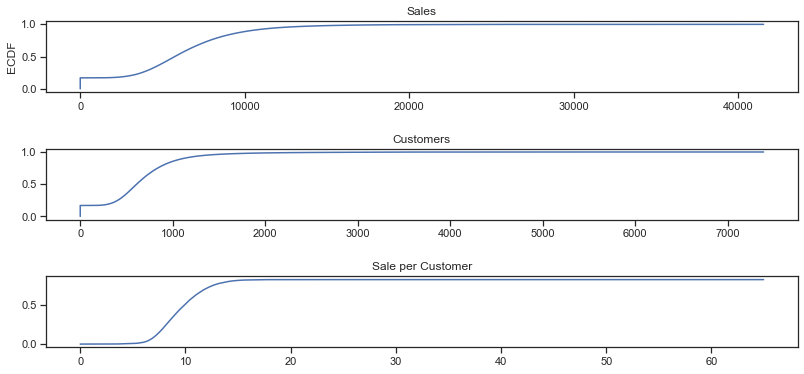

In [8]:
# ECDF: empirical cumulative distribution 
sns.set(style = "ticks")
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.title('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.title('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.title('Sale per Customer');
plt.subplots_adjust(hspace = 0.8)

About 20% of data has zero amount of sales/customers probably due to the fact that the store is closed for state holidays or school holidays

### Data Wrangling 

In [9]:
# Copy data for cleaning
df_sales = train.copy()
df_store = store.copy()

#### Train data 

In [10]:
# Closed Stores with zero sales
df_sales[(df_sales.Open == 0) & (df_sales.Sales == 0)].head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
291     292          5 2015-07-31      0          0     0      1            0   
875     876          5 2015-07-31      0          0     0      1            0   
1406    292          4 2015-07-30      0          0     0      1            0   
1990    876          4 2015-07-30      0          0     0      1            0   
2521    292          3 2015-07-29      0          0     0      1            0   

      SchoolHoliday  Year  Month  Day  WeekOfYear  SalePerCustomer  
291               1  2015      7   31          31              NaN  
875               1  2015      7   31          31              NaN  
1406              1  2015      7   30          31              NaN  
1990              1  2015      7   30          31              NaN  
2521              1  2015      7   29          31              NaN

In [11]:
len(df_sales[(df_sales.Open == 0) & (df_sales.Sales == 0)])

172817

There're 172817 closed stores in the data. It is about 10% of the total amount of observations.

In [12]:
# Opened stores with zero sales
df_sales[(df_sales.Open == 1) & (df_sales.Sales == 0)].head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
86825     971          5 2015-05-15      0          0     1      0   
142278    674          4 2015-03-26      0          0     1      0   
196938    699          4 2015-02-05      0          0     1      1   
322053    708          3 2014-10-01      0          0     1      1   
330176    357          1 2014-09-22      0          0     1      0   

       StateHoliday  SchoolHoliday  Year  Month  Day  WeekOfYear  \
86825             0              1  2015      5   15          20   
142278            0              0  2015      3   26          13   
196938            0              0  2015      2    5           6   
322053            0              0  2014     10    1          40   
330176            0              0  2014      9   22          39   

        SalePerCustomer  
86825               NaN  
142278              NaN  
196938              NaN  
322053              NaN  
330176              NaN

In [13]:
len(df_sales[(df_sales.Open == 1) & (df_sales.Sales == 0)])

54

There're 54 opend stores but no sales in the data.To avoid any biased forecasts we will drop these values.

In [14]:
# Drop data
df_sales = df_sales[(df_sales["Open"] != 0) & (df_sales['Sales'] != 0)]

In [15]:
df_sales.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  Year  Month  Day  WeekOfYear  SalePerCustomer  
0              1  2015      7   31          31         9.482883  
1              1  2015      7   31          31         9.702400  
2              1  2015      7   31          31        10.126675  
3              1  2015      7   31          31         9.342457  
4              1  2015      7   31          31         8.626118

In [16]:
df_sales.shape

(844338, 14)

#### Store data

In [17]:
df_store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [18]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [19]:
# Null value
df_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [20]:
# Missing values in CompetitionDistance
df_store[pd.isnull(df_store.CompetitionDistance)]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

In [21]:
# Fill NaN with a median value (skewed distribuion)
df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(), inplace = True)

In [22]:
# Fill other NA by 0
df_store.fillna(0, inplace = True)

In [23]:
# Join sales and store data
df_clean = pd.merge(df_sales, df_store, how = 'inner', on = 'Store')
df_clean.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      1          4 2015-07-30   5020        546     1      1            0   
2      1          3 2015-07-29   4782        523     1      1            0   
3      1          2 2015-07-28   5011        560     1      1            0   
4      1          1 2015-07-27   6102        612     1      1            0   

   SchoolHoliday  Year  ...  SalePerCustomer  StoreType  Assortment  \
0              1  2015  ...         9.482883          c           a   
1              1  2015  ...         9.194139          c           a   
2              1  2015  ...         9.143403          c           a   
3              1  2015  ...         8.948214          c           a   
4              1  2015  ...         9.970588          c           a   

   CompetitionDistance CompetitionOpenSinceMonth CompetitionOpenSinceYear  \
0               1270.0                       9.0                   2008.0   
1               1270.0                       9.0                   2008.0   
2               1270.0                       9.0                   2008.0   
3               1270.0                       9.0                   2008.0   
4               1270.0                       9.0                   2008.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear  PromoInterval  
0       0              0.0              0.0              0  
1       0              0.0              0.0              0  
2       0              0.0              0.0              0  
3       0              0.0              0.0              0  
4       0              0.0              0.0              0  

[5 rows x 23 columns]

### Data analysis

In [24]:
# Sales distribution among stores
df_clean.groupby('StoreType')['Sales'].describe()

count          mean          std     min      25%     50%  \
StoreType                                                                 
a          457042.0   6925.697986  3277.351589    46.0  4695.25  6285.0   
b           15560.0  10233.380141  5155.729868  1252.0  6345.75  9130.0   
c          112968.0   6933.126425  2896.958579   133.0  4916.00  6408.0   
d          258768.0   6822.300064  2556.401455   538.0  5050.00  6395.0   

                75%      max  
StoreType                     
a           8406.00  41551.0  
b          13184.25  38722.0  
c           8349.25  31448.0  
d           8123.25  38037.0

StoreType B has the highest average of Sales among all others, however we have much less data for it.

In [25]:
# Total sales and customers among stores
df_clean.groupby('StoreType')['Customers', 'Sales'].sum()

Customers       Sales
StoreType                       
a          363541431  3165334859
b           31465616   159231395
c           92129705   783221426
d          156904995  1765392943

StoreType A comes as first, StoreType D goes on the second place in both Sale and Customers

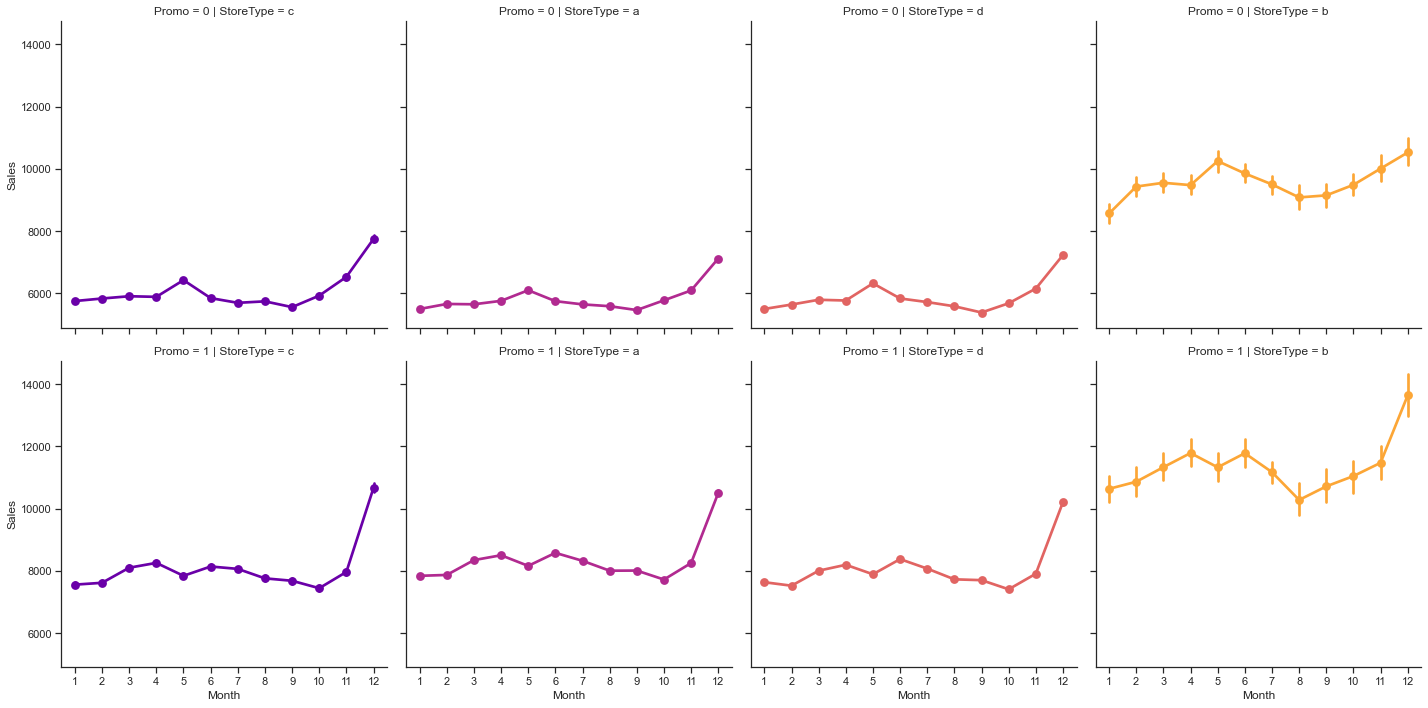

In [26]:
# sales trends
sns.factorplot(data = df_clean, x = 'Month', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo') 

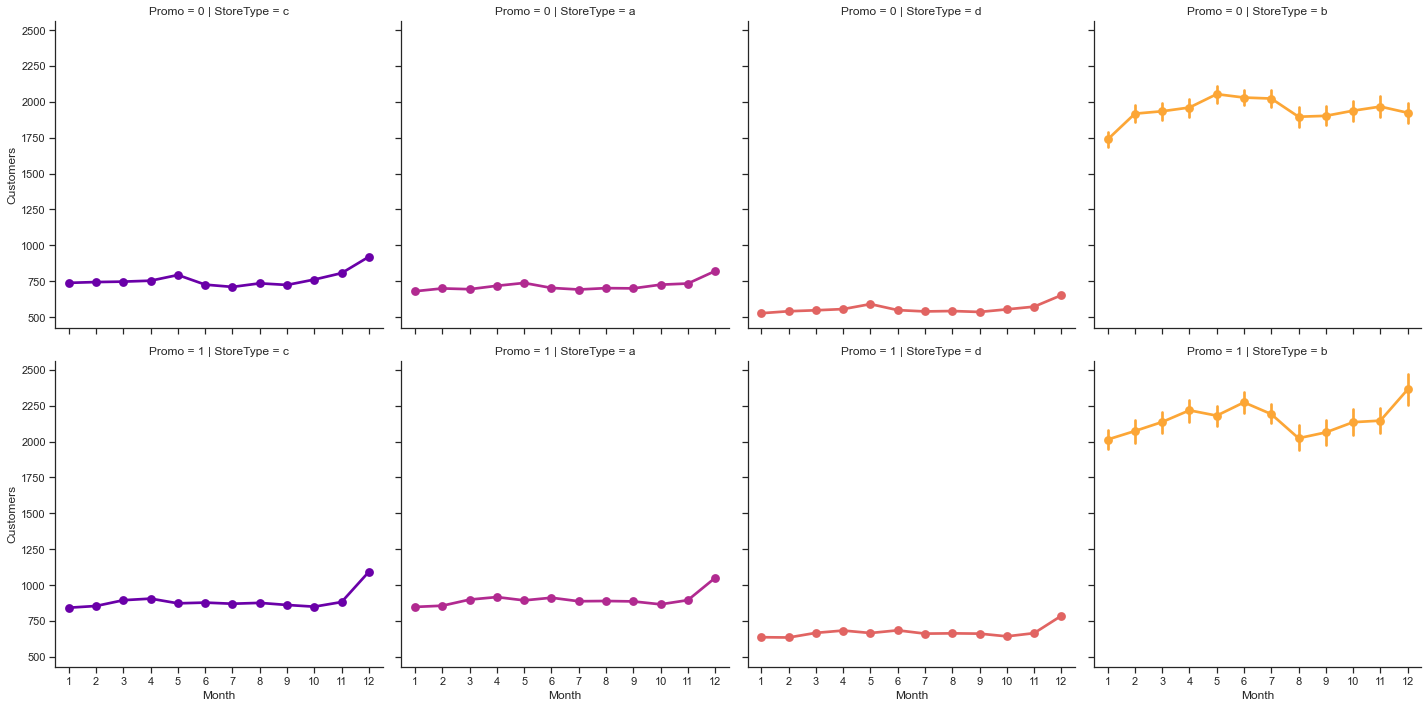

In [27]:
# sales trends
sns.factorplot(data = df_clean, x = 'Month', y = "Customers", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo') 

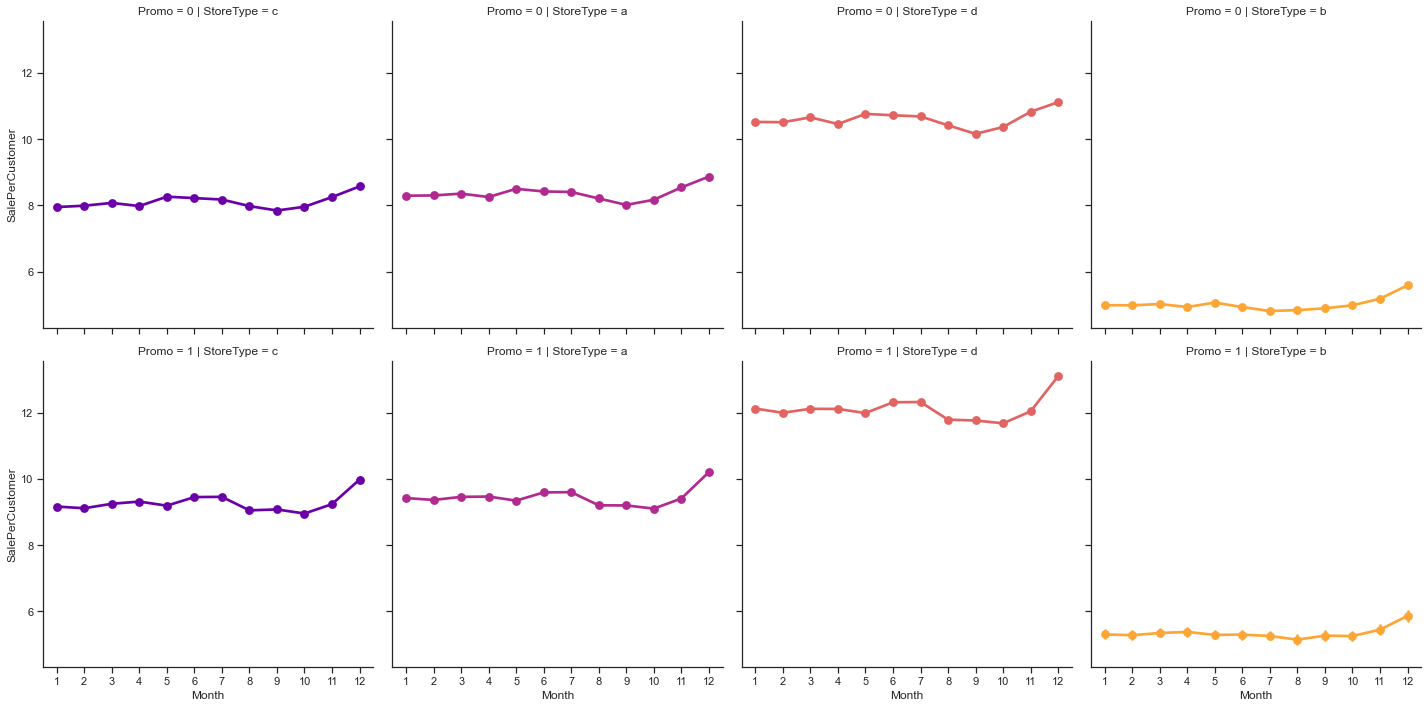

In [28]:
# sale per customer trends
sns.factorplot(data = df_clean, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo') 

The plots above showed StoreType B as the most selling store but it is not true. The highest SalePerCustomer amount is observed at the StoreType D, about 12€ with Promo and 10€ without. As for StoreType A and C it is about 9€.


### Conclusion of EDA
+ The most selling and crowded StoreType is A.
+ Best "Sale per Customer" StoreType D.
+ Low SalePerCustomer amount for StoreType B. 
+ Customers tends to buy more on Modays when there's one promotion (Promo) and on Sundays when there's no promotion at all (both Promo and Promo1 are equal to 0).
+ Promo2 alone doesn't seem to have any significant effect in the Sales.

## Time Series Analysis

+ Time series seems an alternative approach when dealing with continuous values, apart from ML regresions
+ Time in time series is dependant while target values is independant.
+ Seasonality, Trends, Residuals are 3 major things worth being explored in seasonal_decompose. Plus, some special event, holidays, ect, are captured as well.
+ Plotting ACF and PACF is the essential step before choosing which time series model is applyied, such as AR, MA, ARMA, ARIMA, SARIMA.
+ Prophet Facebook function is quite easy to use and is similar to ARIMA family.

#### Seasonality
We chose only one strore, Store 2 for StoreType A to demonstrate the analysis
It also makes sense to downsample the data from days to weeks using the resample method to see the present trends more clearly.

In [29]:
# Choose store 2
store_2 = df_sales[df_sales['Store'] == 2][['Sales', 'Date']]

In [30]:
fig = px.line(store_2,x='Date',y ='Sales')
fig.update_xaxes(
            rangeslider_visible=True,
            rangeselector = dict(
                buttons=list([
                    dict(count=1, label='1y',step='year',stepmode='backward'),
                    dict(count=2, label='2y',step='year',stepmode='backward'),
                    dict(count=3, label='3y',step='year',stepmode='backward'),
                    dict(step='all')
                ])))
fig.show()

In [31]:
store_2['Date'].sort_index(ascending = False, inplace=True)

In [32]:
store_2 = store_2.set_index('Date').resample('W').mean()
store_2.head()

Sales
Date                   
2013-01-06  5926.000000
2013-01-13  4338.333333
2013-01-20  4993.333333
2013-01-27  4667.666667
2013-02-03  5988.000000

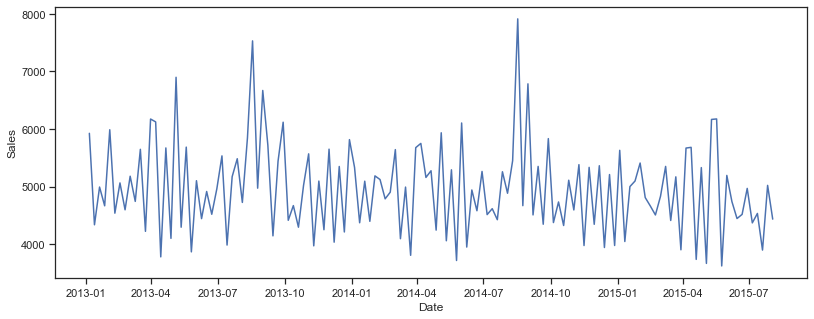

In [33]:
plt.figure(figsize=(12, 5))
sns.lineplot(x=store_2.index, y=store_2['Sales'])

#### Trend, Seasonal, Residual

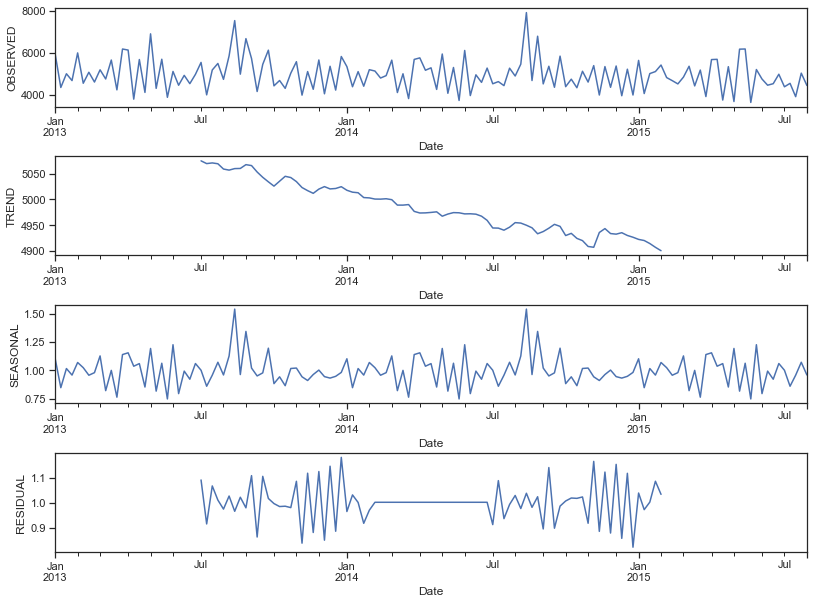

In [34]:
f , (ax1, ax2, ax3, ax4)= plt.subplots(4, figsize = (12, 10))

decomposition = seasonal_decompose(store_2['Sales'], model = 'multiplicative')
decomposition.observed.plot(ax = ax1)
ax1.set_ylabel('OBSERVED')
decomposition.trend.plot(ax = ax2)
ax2.set_ylabel('TREND')
decomposition.seasonal.plot(ax = ax3)
ax3.set_ylabel('SEASONAL')
decomposition.resid.plot(ax = ax4)
ax4.set_ylabel('RESIDUAL')

f.subplots_adjust(hspace = 0.5)


Downward trend with seasonal effect

#### Autocorrelation and Partial Autocorrelation Plot

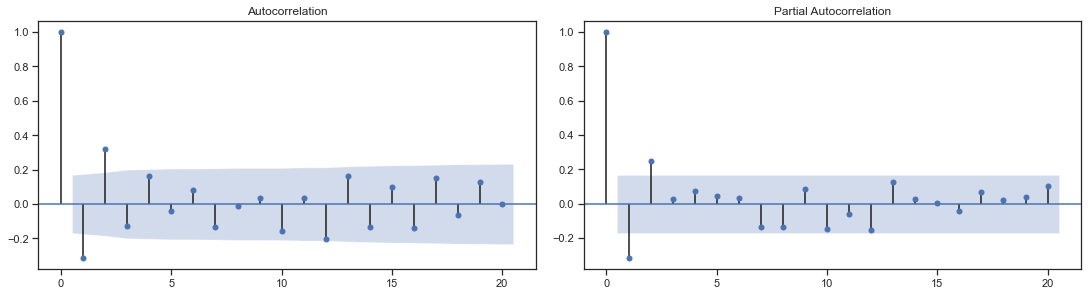

In [35]:
fig = plt.figure(constrained_layout=True, figsize=(15, 4))
grid = gridspec.GridSpec(nrows=1, ncols=2,  figure=fig)

ax1 = fig.add_subplot(grid[0, 0])
plot_acf(store_2['Sales'], lags = 20, ax=ax1);

ax2 = fig.add_subplot(grid[0, 1])
plot_pacf(store_2['Sales'], lags = 20, ax=ax2);

plt.show();

* ACF is a measure of the correlation between the timeseries with a lagged version of itself. I choose lags of 20. ACF help us choose MA model's parameter.
* PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself, after removing the influence of any variance in the middle. PACF helps us choose AR model's parameter.
* Looking at the Autocorrelation plot shows store 2 has stationarity in sales data.

## Time Series Modeling

In [36]:
# Double check data stationary by using adfuller method. 

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())      
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [37]:
adf_test(store_2['Sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.166352e+00
p-value                 2.879655e-10
# lags used             1.000000e+00
# observations          1.330000e+02
critical value (1%)    -3.480500e+00
critical value (5%)    -2.883528e+00
critical value (10%)   -2.578496e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is stationary


The data is good enough to perform time series models.

In [38]:
# Process test data
train = store_2[:120]
test = store_2[120:]
train.head()

Sales
Date                   
2013-01-06  5926.000000
2013-01-13  4338.333333
2013-01-20  4993.333333
2013-01-27  4667.666667
2013-02-03  5988.000000

#### ARMA model

In [39]:
# auto_arima help us choose the optimal model, sometime manually tweaking model hyperparameters yeild better result.
model=auto_arima(train['Sales'],m=7,seasonal=False,
                start_p=0, start_q=0, max_order = 5, test = 'adf',
                error_action='ignore', suppress_warning=True, 
                stepwise=True, trace = True)
             

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=1941.865, BIC=1947.439, Time=0.030 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=1929.888, BIC=1938.250, Time=0.018 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=1935.296, BIC=1943.658, Time=0.018 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=2389.178, BIC=2391.966, Time=0.006 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=1922.722, BIC=1933.872, Time=0.092 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=1924.696, BIC=1938.634, Time=0.049 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=1924.712, BIC=1938.650, Time=0.049 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=1932.060, BIC=1943.210, Time=0.028 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=1926.701, BIC=1943.426, Time=0.207 seconds
Total fit time: 0.511 seconds


In [40]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -957.361
Date:                Sat, 11 Jul 2020   AIC                           1922.722
Time:                        00:39:56   BIC                           1933.872
Sample:                             0   HQIC                          1927.250
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4818.1346    804.188      5.991      0.000    3241.955    6394.314
ar.L1         -0.2433      0.109     -2.241      0.025      -0.456      -0.031
ar.L2          0.2782      0.085      3.255      0.001       0.111       0.446
sigma2      4.982e+05   5.01e+04      9.950      0.000       4e+05    5.96e+05
===================================================================================
Ljung-Box (Q):                       44.13   Jarque-Bera (JB):               102.03
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             1.40
Prob(H) (two-sided):                  0.31   Kurtosis:                         6.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Root Mean Squared Error:  752.7542497108077


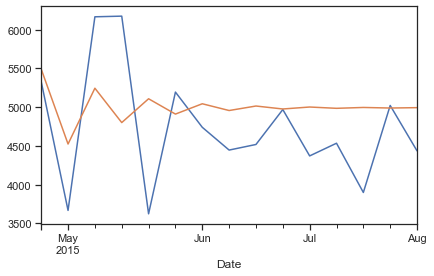

In [41]:
#ARMA
model1 = ARMA(train['Sales'], order=(2,0))
results=model1.fit()

start=len(train)
end=len(train)+len(test)-1

predictions1 = results.predict(start=start, end=end)
predictions1.index = test.index

test['Sales'].plot()
predictions1.plot(label='prediction');

print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(test['Sales'], predictions1)))

#### SARIMA model

In [42]:
model=auto_arima(train['Sales'],m=7,seasonal=True,
                start_p=0, start_q=0, max_order = 5, test = 'adf',
                error_action='ignore', suppress_warning=True, 
                stepwise=True, trace = True)

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(1,0,1,7) [intercept=True]; AIC=1941.633, BIC=1952.783, Time=0.158 seconds
Fit ARIMA(0,0,0)x(0,0,0,7) [intercept=True]; AIC=1941.865, BIC=1947.439, Time=0.007 seconds
Fit ARIMA(1,0,0)x(1,0,0,7) [intercept=True]; AIC=1930.835, BIC=1941.985, Time=0.139 seconds
Fit ARIMA(0,0,1)x(0,0,1,7) [intercept=True]; AIC=1933.338, BIC=1944.488, Time=0.046 seconds
Fit ARIMA(0,0,0)x(0,0,0,7) [intercept=False]; AIC=2389.178, BIC=2391.966, Time=0.009 seconds
Fit ARIMA(1,0,0)x(0,0,0,7) [intercept=True]; AIC=1929.888, BIC=1938.250, Time=0.018 seconds
Fit ARIMA(1,0,0)x(0,0,1,7) [intercept=True]; AIC=1928.040, BIC=1939.190, Time=0.056 seconds
Fit ARIMA(1,0,0)x(1,0,1,7) [intercept=True]; AIC=1930.032, BIC=1943.969, Time=0.393 seconds
Fit ARIMA(1,0,0)x(0,0,2,7) [intercept=True]; AIC=1963.399, BIC=1977.337, Time=0.194 seconds
Near non-invertible roots for order (1, 0, 0)(0, 0, 2, 7); setting score to inf (at least one inverse root too close to the bord

In [43]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 0, [1], 7)   Log Likelihood                -955.475
Date:                             Sat, 11 Jul 2020   AIC                           1920.950
Time:                                     00:40:01   BIC                           1934.887
Sample:                                          0   HQIC                          1926.610
                                             - 120                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4818.1346    864.187      5.575      0.000    3124.359    6511.910
ar.L1         -0.2414      0.113     -2.139      0.032      -0.462      -0.020
ar.L2          0.2763      0.097      2.858      0.004       0.087       0.466
ma.S.L7       -0.1885      0.145     -1.301      0.193      -0.472       0.096
sigma2      4.982e+05   4.99e+04      9.977      0.000       4e+05    5.96e+05
===================================================================================
Ljung-Box (Q):                       37.88   Jarque-Bera (JB):               118.32
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             1.43
Prob(H) (two-sided):                  0.29   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Root Mean Squared Error:  760.1237918187579


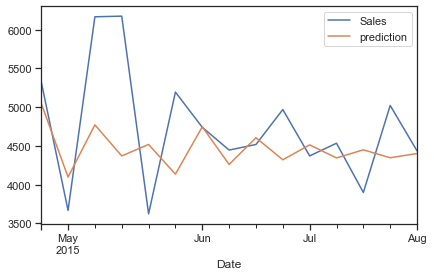

In [44]:
model = SARIMAX(train['Sales'],order=(2, 0, 0),seasonal_order=(0, 0, 1, 7))
results = model.fit()

start=len(train)
end=len(train)+len(test)-1
predictions1 = results.predict(start=start, end=end, dynamic=False)

predictions1.index = test.index

test['Sales'].plot()
predictions1.plot(label='prediction');
plt.legend()

print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(test['Sales'], predictions1)))

#### FB Prophet

In [45]:
df_prophet = store_2.reset_index()[['Date','Sales']].rename({'Date':'ds','Sales':'y'}, axis='columns')
df_prophet.head()

ds            y
0 2013-01-06  5926.000000
1 2013-01-13  4338.333333
2 2013-01-20  4993.333333
3 2013-01-27  4667.666667
4 2013-02-03  5988.000000

In [46]:
df_prophet.tail(20)

ds            y
115 2015-03-22  5170.333333
116 2015-03-29  3904.333333
117 2015-04-05  5670.000000
118 2015-04-12  5682.400000
119 2015-04-19  3737.833333
120 2015-04-26  5331.000000
121 2015-05-03  3668.000000
122 2015-05-10  6167.000000
123 2015-05-17  6175.400000
124 2015-05-24  3624.000000
125 2015-05-31  5195.200000
126 2015-06-07  4740.833333
127 2015-06-14  4446.833333
128 2015-06-21  4519.000000
129 2015-06-28  4969.833333
130 2015-07-05  4371.333333
131 2015-07-12  4535.166667
132 2015-07-19  3899.500000
133 2015-07-26  5022.333333
134 2015-08-02  4436.400000

In [47]:
train_prophet = df_prophet[:120]
test_prophet = df_prophet[120:]

In [48]:
test_prophet.head()

ds       y
120 2015-04-26  5331.0
121 2015-05-03  3668.0
122 2015-05-10  6167.0
123 2015-05-17  6175.4
124 2015-05-24  3624.0

In [58]:
model = Prophet(interval_width=0.95,yearly_seasonality=True,weekly_seasonality=True)

In [59]:
model.fit(train_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [60]:
future = model.make_future_dataframe(periods=15,freq='W')
future.tail()

ds
130 2015-07-05
131 2015-07-12
132 2015-07-19
133 2015-07-26
134 2015-08-02

In [61]:
forecast = model.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(20)

ds         yhat   yhat_lower   yhat_upper
115 2015-03-22  4804.597645  3438.005308  6100.022895
116 2015-03-29  5046.263910  3789.840818  6319.511717
117 2015-04-05  5126.747820  3823.251982  6366.568607
118 2015-04-12  5001.017604  3611.506229  6312.428516
119 2015-04-19  4809.486429  3495.592927  6062.499643
120 2015-04-26  4721.729405  3484.590442  6054.738583
121 2015-05-03  4765.730258  3401.711935  6139.473315
122 2015-05-10  4821.617148  3507.355490  6068.076619
123 2015-05-17  4766.207762  3391.239451  6102.530384
124 2015-05-24  4600.045609  3310.008020  5910.854756
125 2015-05-31  4434.556995  3071.606847  5815.071443
126 2015-06-07  4379.742600  3067.128514  5801.584843
127 2015-06-14  4456.021742  3128.468604  5887.620405
128 2015-06-21  4593.077914  3209.333504  5872.164376
129 2015-06-28  4685.450532  3349.373040  5988.304117
130 2015-07-05  4658.162246  3303.254490  6052.879875
131 2015-07-12  4526.229975  3301.870896  5841.787510
132 2015-07-19  4423.866839  3216.360047  5772.408672
133 2015-07-26  4547.099029  3258.758998  5792.200674
134 2015-08-02  4996.264607  3597.053268  6414.492226

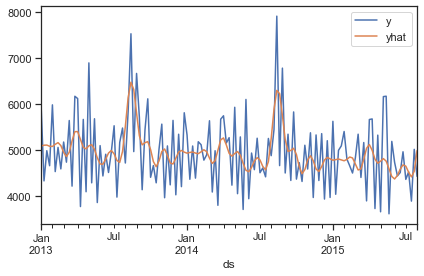

In [62]:
pd.concat([df_prophet.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

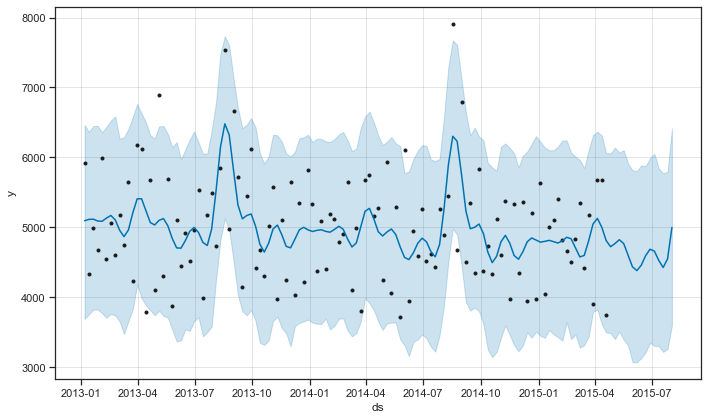

In [63]:
model.plot(forecast);

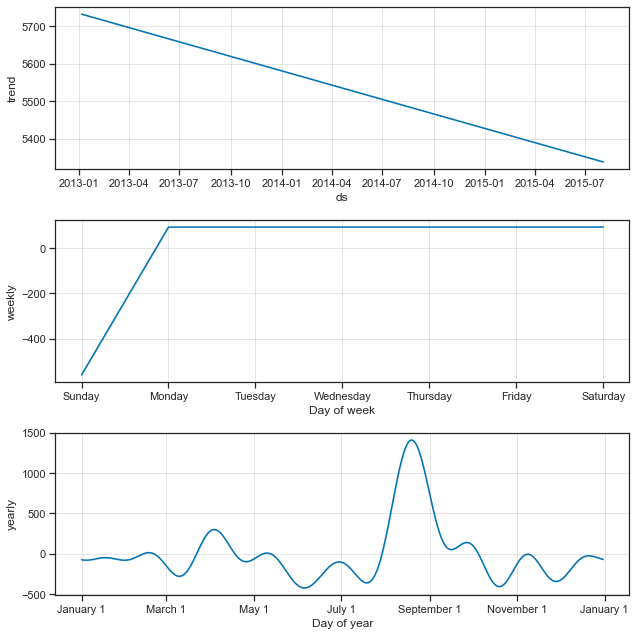

In [64]:
model.plot_components(forecast);

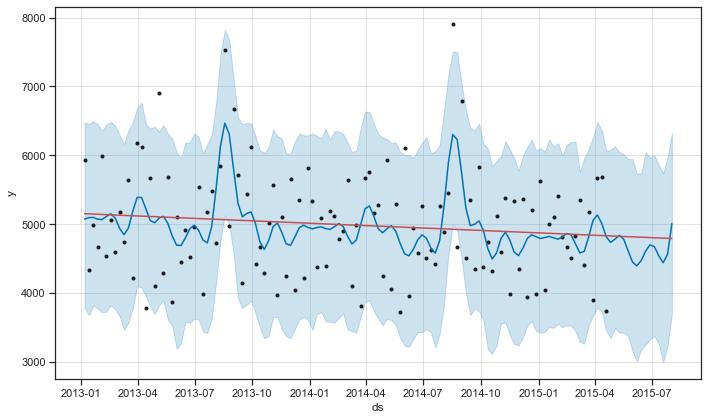

In [57]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),model,forecast)

### LSTM

In [70]:
df=df_sales[df_sales['Store'] == 2][['Sales', 'Date']]
df['Date'].sort_index(ascending = False, inplace=True)

In [71]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(df[['Sales']])

In [80]:
train = int(len(data)*0.75)
train_data,test_data=data[:train],data[train:]

In [85]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [86]:
# reshape into X=t and y=t+1
look_back = 1
train_X, train_y = create_dataset(train_data, look_back)
test_X, test_y = create_dataset(test_data, look_back)

In [87]:
train_X.shape, train_y.shape

((586, 1), (586,))

In [88]:
# reshape input to be [sample, time steps, features] which is required for LSTM
train_X =train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

In [93]:
### Create the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(train_X,train_y,validation_data=(test_X,test_y),epochs=100,batch_size=1,verbose=1)

Train on 586 samples, validate on 194 samples
Epoch 1/100
586/586 [==============================] - 2s 3ms/sample - loss: 0.0382 - val_loss: 0.0270
Epoch 2/100
586/586 [==============================] - 1s 2ms/sample - loss: 0.0332 - val_loss: 0.0275
Epoch 3/100
586/586 [==============================] - 1s 2ms/sample - loss: 0.0333 - val_loss: 0.0270
Epoch 4/100
586/586 [==============================] - 1s 2ms/sample - loss: 0.0334 - val_loss: 0.0269
Epoch 5/100
586/586 [==============================] - 1s 2ms/sample - loss: 0.0339 - val_loss: 0.0298
Epoch 6/100
586/586 [==============================] - 1s 2ms/sample - loss: 0.0328 - val_loss: 0.0286
Epoch 7/100
586/586 [==============================] - 1s 2ms/sample - loss: 0.0335 - val_loss: 0.0284
Epoch 8/100
586/586 [==============================] - 1s 2ms/sample - loss: 0.0334 - val_loss: 0.0273
Epoch 9/100
586/586 [==============================] - 1s 2ms/sample - loss: 0.0333 - val_loss: 0.0269
Epoch 10/100
586/586 [=====

In [94]:
#Model Prediction
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

In [95]:
#Transforming data back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [97]:
## Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(train_y,train_predict))

4984.457457293991